In [203]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow as imshow
import sys, os
from matplotlib import pylab
from ipywidgets import widgets
from IPython.display import display

In [213]:
def trim(org, frame):
    #recursively trim the corners, until no 0 pixles remain 
    #on the outside of the picture after tranformation
    L,R,T,B = 0,0,0,0
    if np.any(frame[0,0]==0): #TL
        L =+ 1
        T =+ 1
    if np.any(frame[-1,0]==0): #TR
        R =+ 1
        T =+ 1
    if np.any(frame[0,-1]==0): #BL
        L =+ 1
        B =+ 1
    if np.any(frame[-1,-1]==0): #BR
        R =+ 1
        B =+ 1
    if L+B+R+T:
        if L:
            frame = frame[L:,:,:]
            org = org[L:,:,:]
        if R:
            frame = frame[:-R,:,:]
            org = org[:-R,:,:]
        if T:
            frame = frame[:,T:,:]
            org = org[:,T:,:]
        if B:
            frame = frame[:,:-B,:]
            org = org[:,:-B,:]
        return trim(org, frame)
    else:
        return org, frame
    
    
def next_to(img1, img2, flip = False):
    #put images next to each other and flip if necessary
    if flip:
        leftimg = img2
        rightimg = img1
    else: 
        leftimg = img1
        rightimg = img2
    
    x,y,c = np.shape(leftimg)
    result = np.zeros((x,2*y, c)).astype(np.uint8)   
    result[:,:y] = leftimg.astype(np.uint8)
    result[:,y:] = rightimg.astype(np.uint8)
    return result #cv2.cvtColor(result, cv2.cv2.COLOR_RGB2BGR)

def align_imgs(base, curr, FLIP, NEXT = True, ROT = False):
    # convert to grayscale
    base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)
    

    
    # find perspective transformation using the arrays of corresponding points
    # then transform the images and overlay them to see if they align properly
    # not what I do in the actual program, just for use in the example code
    # so that you can see how they align, if you decide to run it
    height, width = curr.shape[:2]
    if ROT == None:
        mod_photo = curr
    elif ROT:
        print('rotating')
        
        # Find size of image1
        sz = curr.shape

        # Define the motion model
        warp_mode = cv2.MOTION_EUCLIDEAN #MOTION_TRANSLATION #cv2.MOTION_HOMOGRAPHY#

        # Define 2x3 or 3x3 matrices and initialize the matrix to identity
        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            warp_matrix = np.eye(3, 3, dtype=np.float32)
        else:
            warp_matrix = np.eye(2, 3, dtype=np.float32)

        # Specify the number of iterations.
        number_of_iterations = 5000;

        # Specify the threshold of the increment
        # in the correlation coefficient between two iterations
        termination_eps = 1e-7;

        # Define termination criteria
        
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
        print('starting alignment')
        # Run the ECC algorithm. The results are stored in warp_matrix.
        (cc, transformation) = cv2.findTransformECC (base_gray,curr_gray, warp_matrix, warp_mode, criteria)
        print('finished alignment')
        
    
        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            # Use Perspective warp when the transformation is a Homography
            mod_photo = cv2.warpPerspective (curr, transformation, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        else :
            # Use Affine warp when the transformation is not a Homography
            mod_photo = cv2.warpAffine(curr, transformation, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
        
       
        
    else:
        print('affine transform')
        # find the coordinates of good features to track  in base
        base_features = cv2.goodFeaturesToTrack(base_gray, 3000, .01, 10)

        # find corresponding features in current photo
        curr_features = np.array([])
        curr_features, pyr_stati, _ = cv2.calcOpticalFlowPyrLK(base, curr, base_features, curr_features, flags=1)

        # only add features for which a match was found to the pruned arrays
        base_features_pruned = []
        curr_features_pruned = []
        for index, status in enumerate(pyr_stati):
            if status == 1:
                base_features_pruned.append(base_features[index])
                curr_features_pruned.append(curr_features[index])

        # convert lists to numpy arrays so they can be passed to opencv function
        bf_final = np.asarray(base_features_pruned)
        cf_final = np.asarray(curr_features_pruned)
        transformation, hom_stati = cv2.findHomography(cf_final, bf_final, method=cv2.RANSAC, ransacReprojThreshold=1)
        mod_photo = cv2.warpPerspective(curr, transformation, (width, height))
    
    
    #trim the photo
    base_trim, mod_trim = trim(base, mod_photo)

    if NEXT:#put them next to each other
        result = next_to(base_trim, mod_trim, FLIP)
        return result
    else:
        return base_trim, mod_trim

#result = align_imgs(base, curr, FLIP, NEXT = True, ROT = True)
#plt.imshow(cv2.cvtColor(result, cv2.cv2.COLOR_RGB2BGR))
    
    
    

In [122]:
pylab.rcParams['figure.figsize'] = (16.0, 18.0)
def f(CROPx, CROPy, RESZ, FLIP, ALGN, SAVE):
    fldr = "G:\\temp\\2D3D\\"
    fig1 = "20171014_Wetterkogel-0044.jpg"
    fig2 = "20171014_Wetterkogel-0045.jpg"

    base = cv2.imread(fldr + fig1)
    curr = cv2.imread(fldr + fig2)
    print("Inputshape: ",np.shape(base)[:2])
    
    if CROPx or CROPy:
        x = CROPx+1
        y = CROPy
        base = base[x:-x,y:-y]
        curr = curr[x:-x,y:-y]

    if RESZ:
        
        base = cv2.resize(base, (0,0), fx=RESZ, fy=RESZ)
        curr = cv2.resize(curr, (0,0), fx=RESZ, fy=RESZ)
        

    if ALGN:
        result = align_imgs(base, curr, FLIP)
    else:
        result = next_to(base, curr, FLIP)
    plt.imshow(cv2.cvtColor(result, cv2.cv2.COLOR_RGB2BGR))
    
    if SAVE:
        #save the file
        savetext = fldr + os.path.splitext(fig1)[0] + "_3D" + os.path.splitext(fig1)[1]
        print("saving as: ",savetext)
        cv2.imwrite(savetext, result)
    print("Outputshape: ",np.shape(base)[:2])
    return

a_slider = widgets.IntSlider(min=1, max=500, step=1, value=1)
b_slider = widgets.IntSlider(min=1, max=500, step=1, value=1)
c_slider = widgets.FloatSlider(min=0.01, max=1, step=0.05, value=1)
#button.on_click(show_img)
widgets.interact_manual(f, CROPx=a_slider, CROPy=b_slider, RESZ = c_slider,
                        FLIP = True, ALGN = False, SAVE = False)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<function __main__.f>

## Create Gif

In [ ]:
1 2 3 4 5 6 7 
0 4 2 0 

In [72]:
lookup = np.arange(2*numimgs+1)
lookup

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

rotating
starting alignment
finished alignment


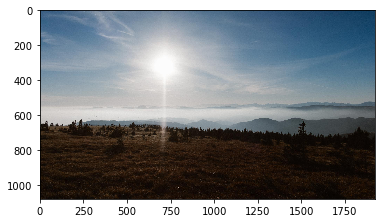

In [219]:

fldr = "G:\\temp\\2D3D\\"
fig1 = "20171014_Wetterkogel-0051.jpg"
fig2 = "20171014_Wetterkogel-0052.jpg"
savefldr = "G:\\temp\\2D3D\\temp\\"

base = cv2.imread(fldr + fig1)
curr = cv2.imread(fldr + fig2)
RESZ = 1
base = cv2.resize(base, (0,0), fx=RESZ, fy=RESZ)
curr = cv2.resize(curr, (0,0), fx=RESZ, fy=RESZ)
plt.imshow(cv2.cvtColor(curr, cv2.cv2.COLOR_RGB2BGR))

base, curr = align_imgs(base, curr, FLIP, NEXT = False, ROT = True)


lookup = [0,0,0,1,2,3,3,3,2,1]
outnamebase = savefldr + os.path.splitext(fig1)[0]

for i in range(0,len(lookup)):
    weight = lookup[i]/max(lookup)
    #get the blended frames in between
    mid_frame = cv2.addWeighted(base,weight,curr,1-weight,0)
    savetext = outnamebase + '_' + str(i) + os.path.splitext(fig1)[1]
    cv2.imwrite(savetext, mid_frame)


filename = 'D:\\ImageMagick-7.0.7-Q16\\convert.exe' 
param = '-delay 7 *.jpg '  
outname = outnamebase + '.gif ' 
    
! {filename} {param} {outname}
! {'rm ' + '*.jpg'}


In [7]:
file = open('blob_fileList.txt', 'w')
for item in (fig1,fig2):
    file.write("%s\n" % item)

file.close()

In [94]:
import os, sys
import glob
dataDir = 'G:\\temp\\2D3D\\temp' #must contain only image files
#change directory gif directory
os.chdir(dataDir)



#verifies correct convert command is being used, then converts gif and png to new gif
os.system('SETLOCAL EnableDelayedExpansion')
os.system('SET IMCONV="D:\\ImageMagick-7.0.7-Q16')
# The following line is where you can set delay of images (100)
os.system('%IMCONV% *.jpg -delay 100 @fileList.txt theblob.gif')

1

In [100]:
! {filename} {rest}